In [49]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew, f_oneway
from utils_eeg import hypers, utils
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
skf = StratifiedKFold(n_splits=hypers.num_folds, shuffle=True)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from xgboost import XGBClassifier # XGBoost
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, average_precision_score, recall_score, f1_score, classification_report, make_scorer, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
import mne
import pywt
import random
from sklearn.decomposition import PCA

import pickle, joblib

import warnings
warnings.filterwarnings('ignore')

# import glob 
# import math
# import re
# from scipy.stats import uniform
# from matplotlib.ticker import MaxNLocator

# import scipy # wavelet

# from mne import Epochs, pick_types, events_from_annotations
# from mne.io import concatenate_raws
# from mne.io import read_raw_edf
# from mne.datasets import eegbci

# from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc, precision_recall_curve

## 0. Approach

```
1. DWT: decompose signals into frequency sub-bands
2. Extract features: get statistical features from sub-bands to represent the distribution of wavelet coefficients 
3. PCA, ICA or LDA: reduce dimension
4. SVM: classify into seizure or non-seizure
```

## 1. read preparation

#### check original channels

In [2]:
raw_eeg = mne.io.read_raw_edf(r'./DataSection-EEG/train_val/data/H20220117_1.edf', preload=False, verbose=False) # read .edf
data, times = raw_eeg[:, :]
print(times.shape, times[0] - times[1])
channel_names = raw_eeg.ch_names
print(len(channel_names), channel_names) 

(21600000,) -0.002
35 ['EEG Fp1-Ref', 'EEG Fp2-Ref', 'EEG F3-Ref', 'EEG F4-Ref', 'EEG C3-Ref', 'EEG C4-Ref', 'EEG P3-Ref', 'EEG P4-Ref', 'EEG O1-Ref', 'EEG O2-Ref', 'EEG F7-Ref', 'EEG F8-Ref', 'EEG T3-Ref', 'EEG T4-Ref', 'EEG T5-Ref', 'EEG T6-Ref', 'EEG Fz-Ref', 'EEG Cz-Ref', 'EEG Pz-Ref', 'POL E', 'POL PG1', 'POL PG2', 'EEG A1-Ref', 'EEG A2-Ref', 'POL T1', 'POL T2', 'POL X1', 'POL X2', 'POL X3', 'POL X4', 'POL X5', 'POL X6', 'POL X7', 'POL $A1', 'POL $A2']


#### CHB-MIT channels (23)
```
'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 
'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 
'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 
'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 
'FT9-FT10', 'FT10-T8', 'T8-P8-1'
```

#### DataSection all channels (35)
```
'Fp1', 'Fp2', 'F3', 'F4', 'C3', 
'C4', 'P3', 'P4', 'O1', 'O2', 
'F7', 'F8', 'T3', 'T4', 'T5', 
'T6', 'Fz', 'Cz', 'Pz', 'POL E', 
'POL PG1', 'POL PG2', 'A1', 'A2', 'POL T1', 
'POL T2', 'POL X1', 'POL X2', 'POL X3', 'POL X4', 
'POL X5', 'POL X6', 'POL X7', 'POL $A1', 'POL $A2'
```

#### DataSection used channels (18 of 35)
```
'Fp1-F7,', 'F7-F3,', 'T3-T5,', 'T5-O1,', 'Fp2-F8,',
'F8-T4,', 'T4-T6,', 'T6-O2,', 'Fp1-F3,', 'F3-C3,', 
'C3-P3,', 'P3-O1,', 'Fp2-F4,', 'F4-C4,', 'C4-P4,', 
'P4-O2,', 'Fz-Cz,', 'Cz-Pz,' 
```

#### DataSection use channels following to CHB-MIT (? of 35)
```
'FP1-F7'(OK), 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'(OK), 
'F3-C3'(OK), 'C3-P3'(OK), 'P3-O1(OK)', 'FP2-F4(OK)', 'F4-C4(OK)', 
'C4-P4(OK)', 'P4-O2'(OK), 'FP2-F8'(OK), 'F8-T8', 'T8-P8-0', 
'P8-O2', 'FZ-CZ'(OK), 'CZ-PZ', 'P7-T7', 'T7-FT9', 
'FT9-FT10', 'FT10-T8', 'T8-P8-1'
```

In [3]:
# channel_indices = [
#     (0, 10), (0, 2), (2, 4), (4, 6), (6, 8), (1, 3), 
#     (3, 5), (5, 7), (7, 9), (1, 11), ()
# ]

In [5]:
##### DataSection 18 channels
use_channel_names = [
    'Fp1-F7,', 'F7-F3,', 'T3-T5,', 'T5-O1,', 'Fp2-F8,',
    'F8-T4,', 'T4-T6,', 'T6-O2,', 'Fp1-F3,', 'F3-C3,', 
    'C3-P3,', 'P3-O1,', 'Fp2-F4,', 'F4-C4,', 'C4-P4,', 
    'P4-O2,', 'Fz-Cz,', 'Cz-Pz,' 
]

(channel_names[0], channel_names[10]), (channel_names[10], channel_names[2]), (channel_names[12], channel_names[14]), (channel_names[14], channel_names[8]), (channel_names[1], channel_names[11]), (channel_names[11], channel_names[13]), (channel_names[13], channel_names[15]), (channel_names[15], channel_names[9]), (channel_names[0], channel_names[2]), (channel_names[2], channel_names[4]), (channel_names[4], channel_names[6]), (channel_names[6], channel_names[8]), (channel_names[1], channel_names[3]), (channel_names[3], channel_names[5]), (channel_names[5], channel_names[7]), (channel_names[7], channel_names[9]), (channel_names[16], channel_names[17]), (channel_names[17], channel_names[18])

# ##### DataSection ? channels following to CHB-MIT
# use_channel_names = [
#     'Fp1-F7,', 'F7-F3,', 'T3-T5,', 'T5-O1,', 'Fp2-F8,',
#     'F8-T4,', 'T4-T6,', 'T6-O2,', 'Fp1-F3,', 'F3-C3,', 
#     'C3-P3,', 'P3-O1,', 'Fp2-F4,', 'F4-C4,', 'C4-P4,', 
#     'P4-O2,', 'Fz-Cz,', 'Cz-Pz,' 
# ]

# (channel_names[0], channel_names[10]), (channel_names[10], channel_names[2]), (channel_names[12], channel_names[14]), (channel_names[14], channel_names[8]), (channel_names[1], channel_names[11]), (channel_names[11], channel_names[13]), (channel_names[13], channel_names[15]), (channel_names[15], channel_names[9]), (channel_names[0], channel_names[2]), (channel_names[2], channel_names[4]), (channel_names[4], channel_names[6]), (channel_names[6], channel_names[8]), (channel_names[1], channel_names[3]), (channel_names[3], channel_names[5]), (channel_names[5], channel_names[7]), (channel_names[7], channel_names[9]), (channel_names[16], channel_names[17]), (channel_names[17], channel_names[18])

(('EEG Fp1-Ref', 'EEG F7-Ref'),
 ('EEG F7-Ref', 'EEG F3-Ref'),
 ('EEG T3-Ref', 'EEG T5-Ref'),
 ('EEG T5-Ref', 'EEG O1-Ref'),
 ('EEG Fp2-Ref', 'EEG F8-Ref'),
 ('EEG F8-Ref', 'EEG T4-Ref'),
 ('EEG T4-Ref', 'EEG T6-Ref'),
 ('EEG T6-Ref', 'EEG O2-Ref'),
 ('EEG Fp1-Ref', 'EEG F3-Ref'),
 ('EEG F3-Ref', 'EEG C3-Ref'),
 ('EEG C3-Ref', 'EEG P3-Ref'),
 ('EEG P3-Ref', 'EEG O1-Ref'),
 ('EEG Fp2-Ref', 'EEG F4-Ref'),
 ('EEG F4-Ref', 'EEG C4-Ref'),
 ('EEG C4-Ref', 'EEG P4-Ref'),
 ('EEG P4-Ref', 'EEG O2-Ref'),
 ('EEG Fz-Ref', 'EEG Cz-Ref'),
 ('EEG Cz-Ref', 'EEG Pz-Ref'))

#### read labels
```
seizure class: 'rhythmic', 'seiz', 'single'
non-seizure class: 'other', unlabeled (not in json)
```

In [6]:
# # train & val
# seizure_dict_1 = utils.read_label(hypers.label_dir_1, hypers.read_all_classes) 

# # test
# seizure_dict_2 = utils.read_label(hypers.label_dir_2, hypers.read_all_classes) 

In [7]:
# # train & val
# seizure_df_1 = pd.DataFrame(seizure_dict_1).T
# seizure_df_1

In [8]:
# # test
# seizure_df_2 = pd.DataFrame(seizure_dict_2).T
# seizure_df_2

#### read data

#### 1.1 remove abnormal frequency
```
Normal frequency of EEG: 0~50Hz
Band-pass filter: 只传递某频率范围内的信号，由1个Low-pass filter和1个High-pass filter组成
Low-pass filter: 只允许频率低于某频率的信号通过
High-pass filter: 只允许频率高于某频率的信号通过
```

In [9]:
# # train & val
# data_dict_1 = utils.read_data(hypers.data_dir_1, hypers.lowcut, hypers.highcut, hypers.channel_indices, hypers.scaling_factor) 
# # data_df_1 = utils.band_pass(data_df_1, hypers.lowcut, hypers.highcut, hypers.sampling_rate)

# # test
# data_dict_2 = utils.read_data(hypers.data_dir_2, hypers.lowcut, hypers.highcut, hypers.channel_indices, hypers.scaling_factor) 
# # data_df_2 = utils.band_pass(data_df_2, hypers.lowcut, hypers.highcut, hypers.sampling_rate)

In [10]:
# # train & val
# data_df_1 = pd.DataFrame(data_dict_1).T
# data_df_1 = data_df_1.reset_index()
# data_df_1 = data_df_1.rename(columns={'index':'file'})
# data_df_1

In [11]:
# for id_ in range(len(data_df_1)):
#     print(data_df_1['data'][id_].shape)

In [12]:
# # test
# data_df_2 = pd.DataFrame(data_dict_2).T
# data_df_2 = data_df_2.reset_index()
# data_df_2 = data_df_2.rename(columns={'index':'file'})
# data_df_2

In [13]:
# for id_ in range(len(data_df_2)):
#     print(data_df_2['data'][id_].shape)

#### save dataframe to pickle

In [14]:
# # train & val
# data_df_1.to_pickle(hypers.data_dir_1+'data.pkl')
# seizure_df_1.to_pickle(hypers.label_dir_1+'label.pkl')

# # test
# data_df_2.to_pickle(hypers.data_dir_2+'data.pkl')
# seizure_df_2.to_pickle(hypers.label_dir_2+'label.pkl')

#### re-load pickle to dataframe

In [15]:
# train & val
data_df_1 = pd.read_pickle(hypers.data_dir_1+'data.pkl')
seizure_df_1 = pd.read_pickle(hypers.label_dir_1+'label.pkl')

# test
data_df_2 = pd.read_pickle(hypers.data_dir_2+'data.pkl')
seizure_df_2 = pd.read_pickle(hypers.label_dir_2+'label.pkl')

In [16]:
(seizure_df_1['end'] - seizure_df_1['start']) / 500

0       8.002
1       1.904
2       4.168
3      -3.876
4       0.018
        ...  
2127    1.656
2128     1.26
2129    1.288
2130    1.846
2131     1.53
Length: 2132, dtype: object

## 2. original seizure & non-seizure (Time Domain)
```
x-axis: Time[s] 
y-axis: Amplitude (Voltage) [μV] * 10^6 = [pV], e.g. ECG:[mV], EEG:[μV] 
```

#### visualize per person, per channel

-------------------
channel_name Fp1-F7,
-------------------
channel_name F7-F3,
data id: 0
----------All time: non-seizure(black), seizure(red) ----------


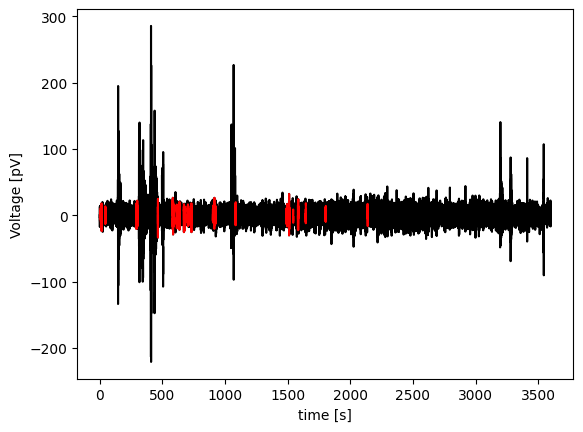

data id: 1
----------All time: non-seizure(black), seizure(red) ----------


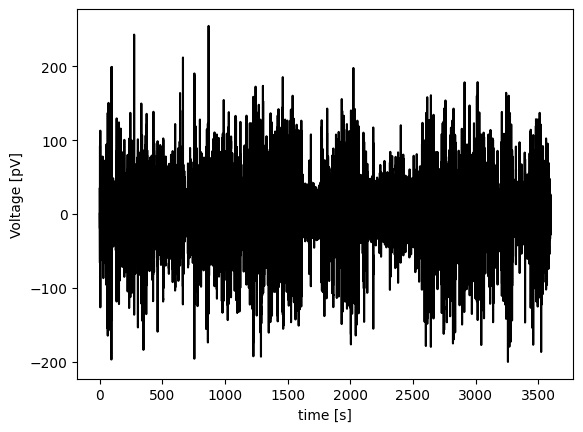

data id: 2
----------All time: non-seizure(black), seizure(red) ----------


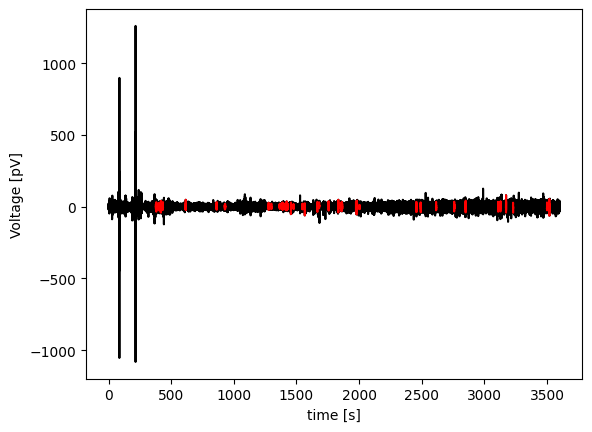

data id: 3
----------All time: non-seizure(black), seizure(red) ----------


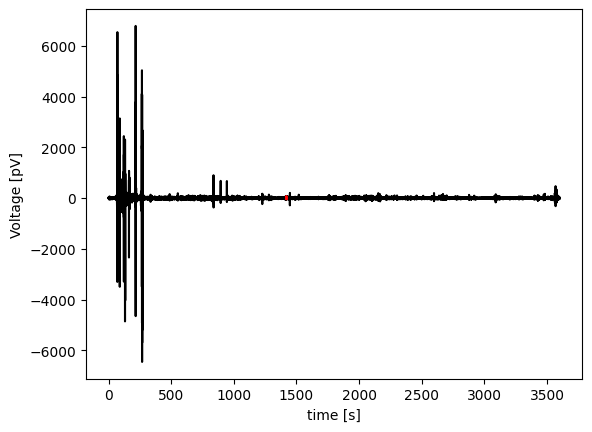

data id: 4
----------All time: non-seizure(black), seizure(red) ----------


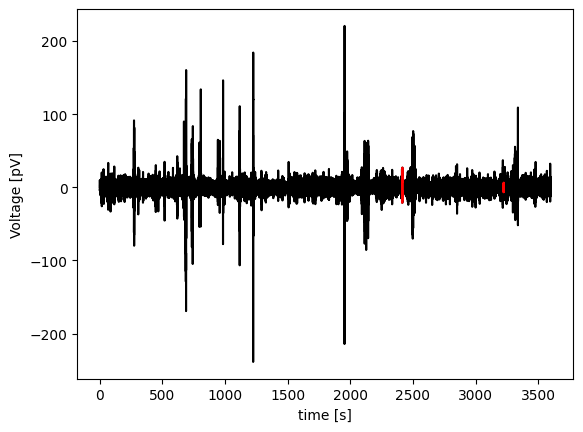

data id: 5
----------All time: non-seizure(black), seizure(red) ----------


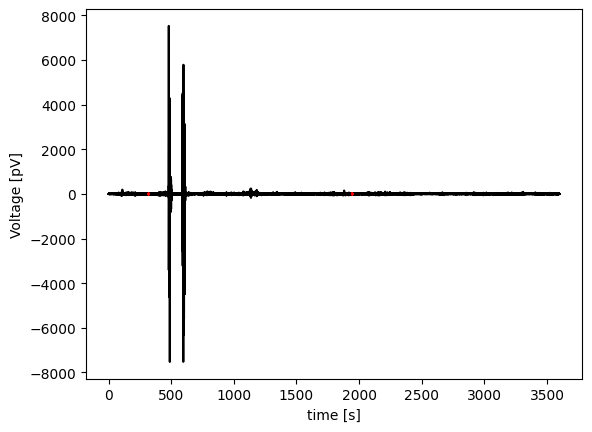

data id: 6
----------All time: non-seizure(black), seizure(red) ----------


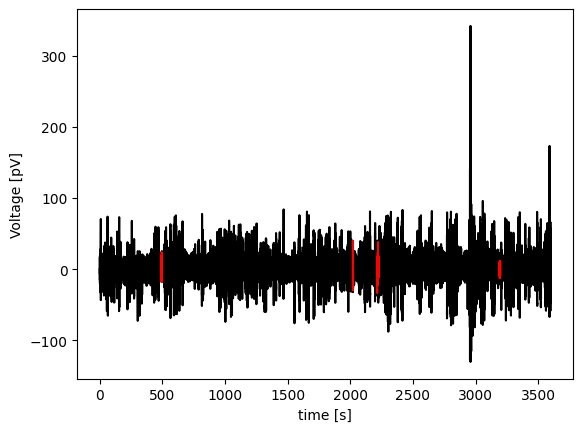

data id: 7
----------All time: non-seizure(black), seizure(red) ----------


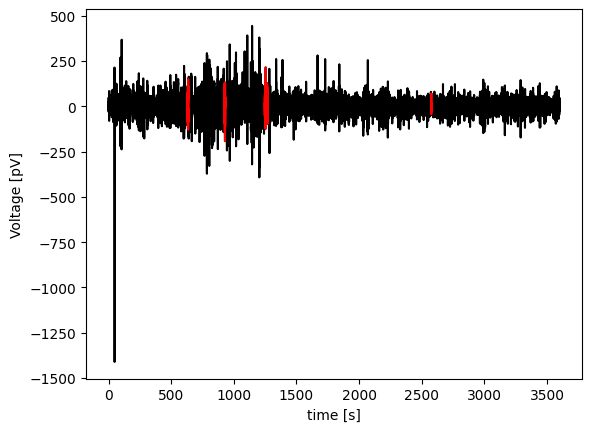

data id: 8
----------All time: non-seizure(black), seizure(red) ----------


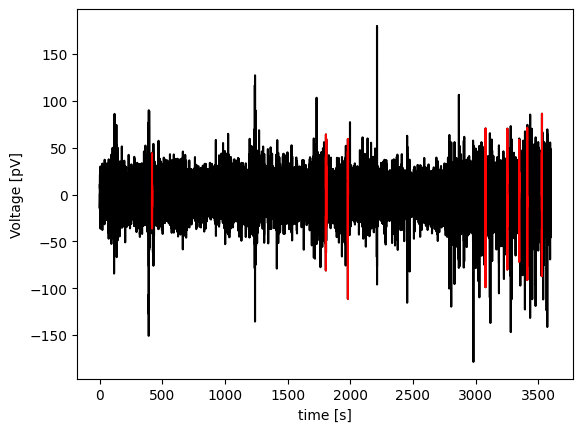

data id: 9
----------All time: non-seizure(black), seizure(red) ----------


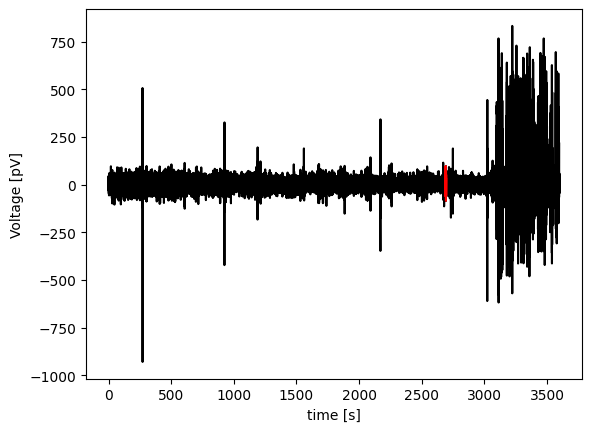

-------------------
channel_name T3-T5,
-------------------
channel_name T5-O1,
-------------------
channel_name Fp2-F8,
-------------------
channel_name F8-T4,
-------------------
channel_name T4-T6,
-------------------
channel_name T6-O2,
-------------------
channel_name Fp1-F3,
-------------------
channel_name F3-C3,
-------------------
channel_name C3-P3,
-------------------
channel_name P3-O1,
-------------------
channel_name Fp2-F4,
-------------------
channel_name F4-C4,
-------------------
channel_name C4-P4,
-------------------
channel_name P4-O2,
-------------------
channel_name Fz-Cz,
-------------------
channel_name Cz-Pz,


In [17]:
for id_channel, channel_name in enumerate(use_channel_names):
    print('-------------------')
    print('channel_name', channel_name)

    if channel_name == 'F7-F3,':
        for i in range(len(data_df_1)):
            print('data id:', i)
            utils.viz_original(data_df_1['file'][i], seizure_df_1, data_df_1, id_channel=id_channel, times=times)

## 3. DWT (Discrete Wavelet Transform)
```
coeffs = pywt.wavedec(data, wavelet, mode, level)
Returns: [An, Dn, Dn-1, …, D2, D1]
```

#### frequency of each sub-band

In [18]:
for i in range(hypers.level):
    lower_limit = hypers.sampling_rate / 2**(i+2)
    upper_limit = hypers.sampling_rate / 2**(i+1)
    print('frequency range (level {}):[{}, {}]'.format(i+1, lower_limit, upper_limit))

print('frequency range (appromaximate):[{}, {}]'.format(0, lower_limit))

frequency range (level 1):[125.0, 250.0]
frequency range (level 2):[62.5, 125.0]
frequency range (level 3):[31.25, 62.5]
frequency range (level 4):[15.625, 31.25]
frequency range (level 5):[7.8125, 15.625]
frequency range (level 6):[3.90625, 7.8125]
frequency range (appromaximate):[0, 3.90625]


#### coefficient number of each sub-band (real)

In [19]:
d = data_df_1['data'][0][:, 0][0:hypers.sampling_rate]

coeffs_0 = pywt.wavedec(data=d, wavelet=hypers.wavelet, level=hypers.level) ##### seizure
print('sum number: {}'.format(sum([len(i) for i in coeffs_0])))
print('approximate: {}'.format(coeffs_0[0].shape))
for i, value in enumerate(coeffs_0[1:]):
    print('level {}: {}'.format(hypers.level-i, value.shape))

sum number: 538
approximate: (14,)
level 6: (14,)
level 5: (22,)
level 4: (37,)
level 3: (68,)
level 2: (130,)
level 1: (253,)


#### coefficient number of each sub-band (theory)

In [20]:
nums = []
for i in range(hypers.level):
    num = len(d) / 2**(i+1)
    print('level {}: {}'.format(i+1, num))
    nums.append(num)
print('approximate: {}'.format(nums[-1]))
print('sum number:', np.sum(nums) + nums[-1])

level 1: 250.0
level 2: 125.0
level 3: 62.5
level 4: 31.25
level 5: 15.625
level 6: 7.8125
approximate: 7.8125
sum number: 500.0


#### visualize 1 file, 1 channel, 1 second

sum number: (500,)
length of approximate coefficients: (14,)
length of detailed coefficients (level 6): (14,)
length of detailed coefficients (level 5): (22,)
length of detailed coefficients (level 4): (37,)
length of detailed coefficients (level 3): (68,)
length of detailed coefficients (level 2): (130,)
length of detailed coefficients (level 1): (253,)


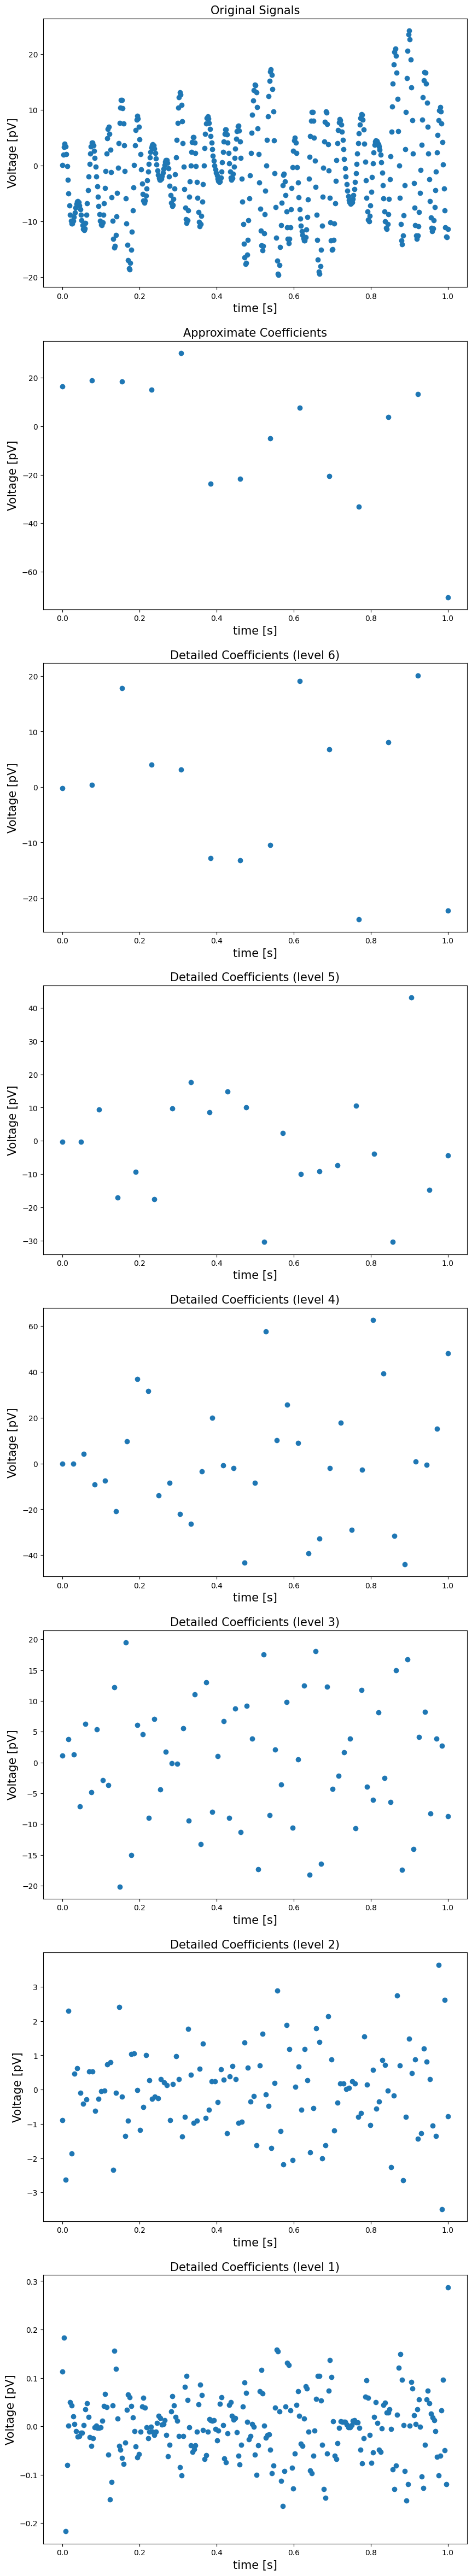

In [21]:
utils.viz_dwt('H20200914_1', data_df_1, id_channel=0, level=hypers.level, wavelet=hypers.wavelet, times=times)

#### 3.1 class 0: DWT for all seizure data (seizure num * channel num * second num)

In [22]:
# train & val
# coeffs_seizure_1 = utils.dwt_seizure_per_window(seizure_df_1, data_df_1, hypers.window_size, hypers.seizure_classes, hypers.sampling_rate, hypers.wavelet, hypers.level)
coeffs_seizure_1 = utils.dwt_seizure_per_overlap_window(seizure_df_1, data_df_1, hypers.window_size, hypers.seizure_classes, hypers.sampling_rate, hypers.wavelet, hypers.level, hypers.moving_size)
print('seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_seizure_1.shape)

# test
# coeffs_seizure_2 = utils.dwt_seizure_per_window(seizure_df_2, data_df_2, hypers.window_size, hypers.seizure_classes, hypers.sampling_rate, hypers.wavelet, hypers.level)
coeffs_seizure_2 = utils.dwt_seizure_per_overlap_window(seizure_df_2, data_df_2, hypers.window_size, hypers.seizure_classes, hypers.sampling_rate, hypers.wavelet, hypers.level, hypers.moving_size)
print('seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_seizure_2.shape)

seizure num * step num, channel num, coeff num (include A ~ D, and label)
(6146, 18, 8)
seizure num * step num, channel num, coeff num (include A ~ D, and label)
(1547, 18, 8)


#### 3.2 class 1: DWT for randomly added non-seizure data (seizure num * channel num * second num)

In [23]:
# train & val
# coeffs_non_seizure_1 = utils.dwt_non_seizure_per_window_one_file(int(len(coeffs_seizure_1)*hypers.label_balance), data_df_1, seizure_df_1, hypers.seizure_classes, hypers.window_size, utils.random_non_seizure_range, hypers.sampling_rate, hypers.wavelet, hypers.level)
coeffs_non_seizure_1 = utils.dwt_non_seizure_per_window_all_files(int(len(coeffs_seizure_1)*hypers.label_balance), data_df_1, seizure_df_1, hypers.seizure_classes, hypers.window_size, utils.random_non_seizure_range, hypers.sampling_rate, hypers.wavelet, hypers.level)
print('non-seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_non_seizure_1.shape)

# test
# coeffs_non_seizure_2 = utils.dwt_non_seizure_per_window_one_file(int(len(coeffs_seizure_2)*hypers.label_balance), data_df_2, seizure_df_2, hypers.seizure_classes, hypers.window_size, utils.random_non_seizure_range, hypers.sampling_rate, hypers.wavelet, hypers.level)
coeffs_non_seizure_2 = utils.dwt_non_seizure_per_window_all_files(int(len(coeffs_seizure_2)*hypers.label_balance), data_df_2, seizure_df_2, hypers.seizure_classes, hypers.window_size, utils.random_non_seizure_range, hypers.sampling_rate, hypers.wavelet, hypers.level)
print('non-seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_non_seizure_2.shape)

non-seizure num * step num, channel num, coeff num (include A ~ D, and label)
(6146, 18, 8)
non-seizure num * step num, channel num, coeff num (include A ~ D, and label)
(1547, 18, 8)


#### 3.3 final all coeffs (seizure + non-seizure)

In [25]:
# train & val
coeffs_1 = np.concatenate((coeffs_seizure_1, coeffs_non_seizure_1), axis=0)
print(coeffs_1.shape)

# test
coeffs_2 = np.concatenate((coeffs_seizure_2, coeffs_non_seizure_2), axis=0)
print(coeffs_2.shape)

(12292, 18, 8)
(3094, 18, 8)


## 4. feature extraction & labels

#### features
```
other features:, number of maxima and minima, variance, COV, RMS, Shannon entropy (CMIM is used to select feature type)
```

In [26]:
import scipy
def extract_features(coeffs):
    features = []
    for i, coeff in enumerate(coeffs):

        # feature 1: absolute -> mean 
        features.append(np.mean(np.abs(coeff)))

        # # feature 2: absolute -> max
        # features.append(np.max(np.abs(coeff)))

        # # feature 3: absolute -> min
        # features.append(np.min(np.abs(coeff)))

        # # feature 4: absolute -> median
        # features.append(np.median(np.abs(coeff))) # slow

        # # feature 5: standard deviation 
        # features.append(np.std(coeff))

        # # feature 6: 过零率（Zero Crossing Rate）：波形穿过零线的次数，可用于描述信号的波动性。
        # features.append(np.sum(np.diff(np.sign(coeff)) != 0) / (2 * len(coeff)))

        # # feature 7: number of peaks
        # peaks, _ = scipy.signal.find_peaks(coeff)
        # features.append(len(peaks)) 

        # # feature 8: 峰度（Kurtosis）
        # features.append(kurtosis(coeff)) # so so slow

        # # feature 9: 和偏度（Skewness）
        # features.append(skew(coeff)) # so so slow

        # feature 10: absolute -> ratio (adjacent sub-band)
        if i != len(coeffs[0:hypers.used_coeff_num]) - 1: # not last
            features.append( np.mean(np.abs(coeffs[i])) / np.mean(np.abs(coeffs[i+1])) ) 
        else: 
            features.append( np.mean(np.abs(coeffs[i])) / 1 )

        # # 功率谱密度（Power Spectral Density）：表示信号在不同频率上的能量分布. 频谱带能量比例（Relative Band Power）：计算在特定频带上的能量相对于总能量的比例。 # so slow
        # freq, psd = welch(coeff, fs=len(coeff))
        # total_power = np.trapz(psd, freq)
        # features.append(total_power) 

        # # 7. SVD 特征
        # # 奇异值分解（Singular Value Decomposition，SVD）的特征：提取信号的主要成分。
        # u, s, vh = np.linalg.svd(eeg_data.reshape(1, -1))
        # svd_feature = s[0]
        # features.append(svd_feature) 

        # # 10. 非线性特征（方差分析法的例子: ANOVA）用于检测信号中的非线性特征。
        # group1 = eeg_data[:500]
        # group2 = eeg_data[500:]
        # f_statistic, p_value = f_oneway(group1, group2)
        # features.append(f_statistic) 
        # features.append(p_value) 

        # # feature x: average power
        # features.append(np.mean(np.square(coeff)))

    return features

extract_features(coeffs_1[0][0][0:hypers.used_coeff_num]) 

[34.768757,
 3.055821,
 11.377877,
 1.780431,
 6.390518,
 2.511153,
 2.5448542,
 2.544854164123535]

In [27]:
# train & val
featuress = []
for i in range(coeffs_1.shape[0]): # each data (each time step)
    features = []
    for j in range(coeffs_1.shape[1]): # each channel
        feature = utils.extract_features(coeffs_1[i][j][0:hypers.used_coeff_num]) # each sub-band (A6, D6, D5, D4), 调用函数 
        features.append(feature)
    featuress.append(features)

X = np.array(featuress)
print('features number:', X.shape)
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2]) 
print('final features number:', X.shape)


# test
featuress = []
for i in range(coeffs_2.shape[0]): # each data
    features = []
    for j in range(coeffs_2.shape[1]): # each channel
        feature = utils.extract_features(coeffs_2[i][j][0:hypers.used_coeff_num]) # each sub-band (A6, D6, D5, D4), 调用函数 
        features.append(feature)
    featuress.append(features)

X_test = np.array(featuress)
print('features number:', X_test.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]) 
print('final features number:', X_test.shape)

features number: (12292, 18, 8)
final features number: (12292, 144)
features number: (3094, 18, 8)
final features number: (3094, 144)


#### labels

In [28]:
# train & val
y = coeffs_1[:, 0, hypers.level+1].astype(np.int32)
print(y.shape)
print('seizure num:', sum(y==0))
print('non-seizure num:', sum(y==1))

# test
y_test = coeffs_2[:, 0, hypers.level+1].astype(np.int32)
print(y_test.shape)
print('seizure num:', sum(y_test==0))
print('non-seizure num:', sum(y_test==1))

(12292,)
seizure num: 6146
non-seizure num: 6146
(3094,)
seizure num: 1547
non-seizure num: 1547


## 5. data analysis & data pre-processing

#### split to train & val

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True) 
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((9833, 144), (2459, 144), (3094, 144), (9833,), (2459,), (3094,))

#### normalization
[机器学习中的数据泄露（Data Leakage）](https://zhuanlan.zhihu.com/p/246482947?utm_id=0)

[容易数据泄露的情况](http://t.csdn.cn/ZuDl8)

[分类问题中的数据不平衡问题（可用异常检测来代替分类）](http://t.csdn.cn/y7WOw)

[数据泄露Data Leakage是什么？你为什么要注意？](https://www.dataapplab.com/an-introduction-to-data-leakage/)
```
只将其应用于train数据, 然后使用相同的缩放参数对val数据进行缩放, 以避免信息泄漏

``````

In [32]:
# get scaling factor via training set
scaler = MinMaxScaler() # normalization
# scaler = StandardScaler() # standardization
scaler.fit(X_train)

MinMaxScaler()

In [33]:
# scale train
print(X_train[:, 0].mean(), X_train[:, 0].std())
X_train = scaler.transform(X_train)
print(X_train[:, 0].mean(), X_train[:, 0].std())

# scale val
print(X_val[:, 0].mean(), X_val[:, 0].std())
X_val = scaler.transform(X_val)
print(X_val[:, 0].mean(), X_val[:, 0].std())

# scale test
print(X_test[:, 0].mean(), X_test[:, 0].std())
X_test = scaler.transform(X_test)
print(X_test[:, 0].mean(), X_test[:, 0].std())

# scale train & val (just for hyperparameter tuning)
print(X[:, 0].mean(), X[:, 0].std())
X = scaler.transform(X)
print(X[:, 0].mean(), X[:, 0].std())

-5.8304553 277.55396
0.66641456 0.012251117
-1.0851718 307.91727
0.66662407 0.013591342
3.0297987 135.54288
0.6668056 0.0059828074
-4.881167 283.8944
0.66645646 0.012530983


#### just for quick check

----------train----------
                precision    recall  f1-score   support

    0: seizure       1.00      1.00      1.00      4895
1: non-seizure       1.00      1.00      1.00      4938

      accuracy                           1.00      9833
     macro avg       1.00      1.00      1.00      9833
  weighted avg       1.00      1.00      1.00      9833



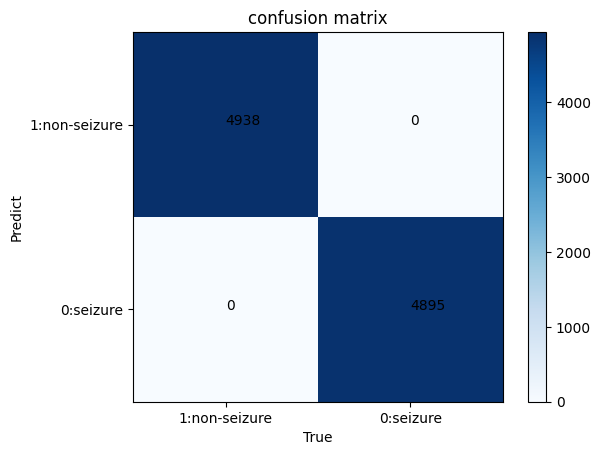

----------val----------
                precision    recall  f1-score   support

    0: seizure       0.94      0.92      0.93      1251
1: non-seizure       0.92      0.93      0.93      1208

      accuracy                           0.93      2459
     macro avg       0.93      0.93      0.93      2459
  weighted avg       0.93      0.93      0.93      2459



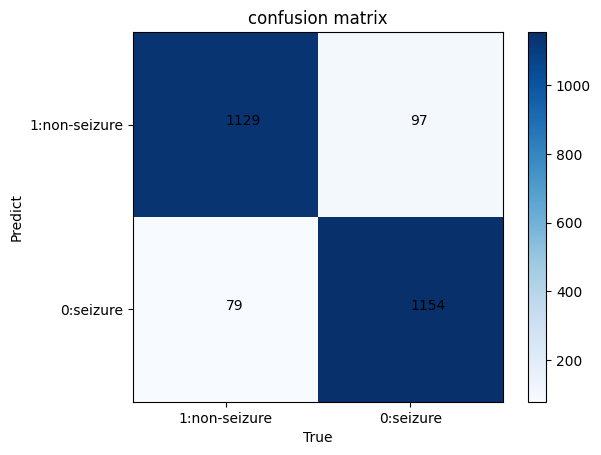

----------test----------
                precision    recall  f1-score   support

    0: seizure       0.84      0.76      0.80      1547
1: non-seizure       0.78      0.85      0.82      1547

      accuracy                           0.81      3094
     macro avg       0.81      0.81      0.81      3094
  weighted avg       0.81      0.81      0.81      3094



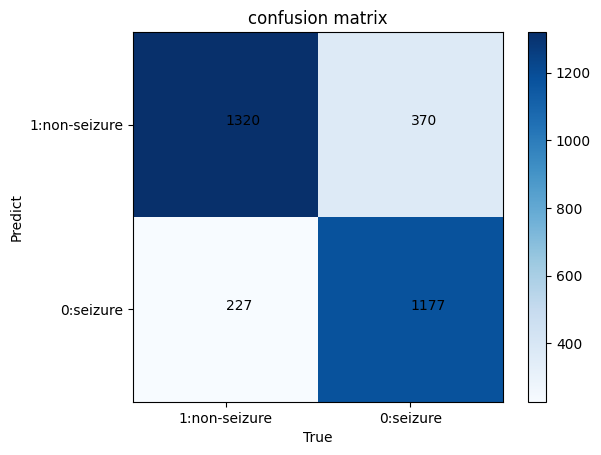

In [34]:
# clf = SVC(kernel='rbf', C=10, gamma=0.1, probability=True)
clf = XGBClassifier(verbosity=0, probability=True)
clf.fit(X_train, y_train)

# train
print('----------train----------')
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred, target_names=hypers.labels))
utils.confusion_matrix(y_train, y_pred)

# val
print('----------val----------')
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=hypers.labels))
utils.confusion_matrix(y_val, y_pred)

# test
print('----------test----------')
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=hypers.labels))
utils.confusion_matrix(y_test, y_pred)

#### correlation coefficient

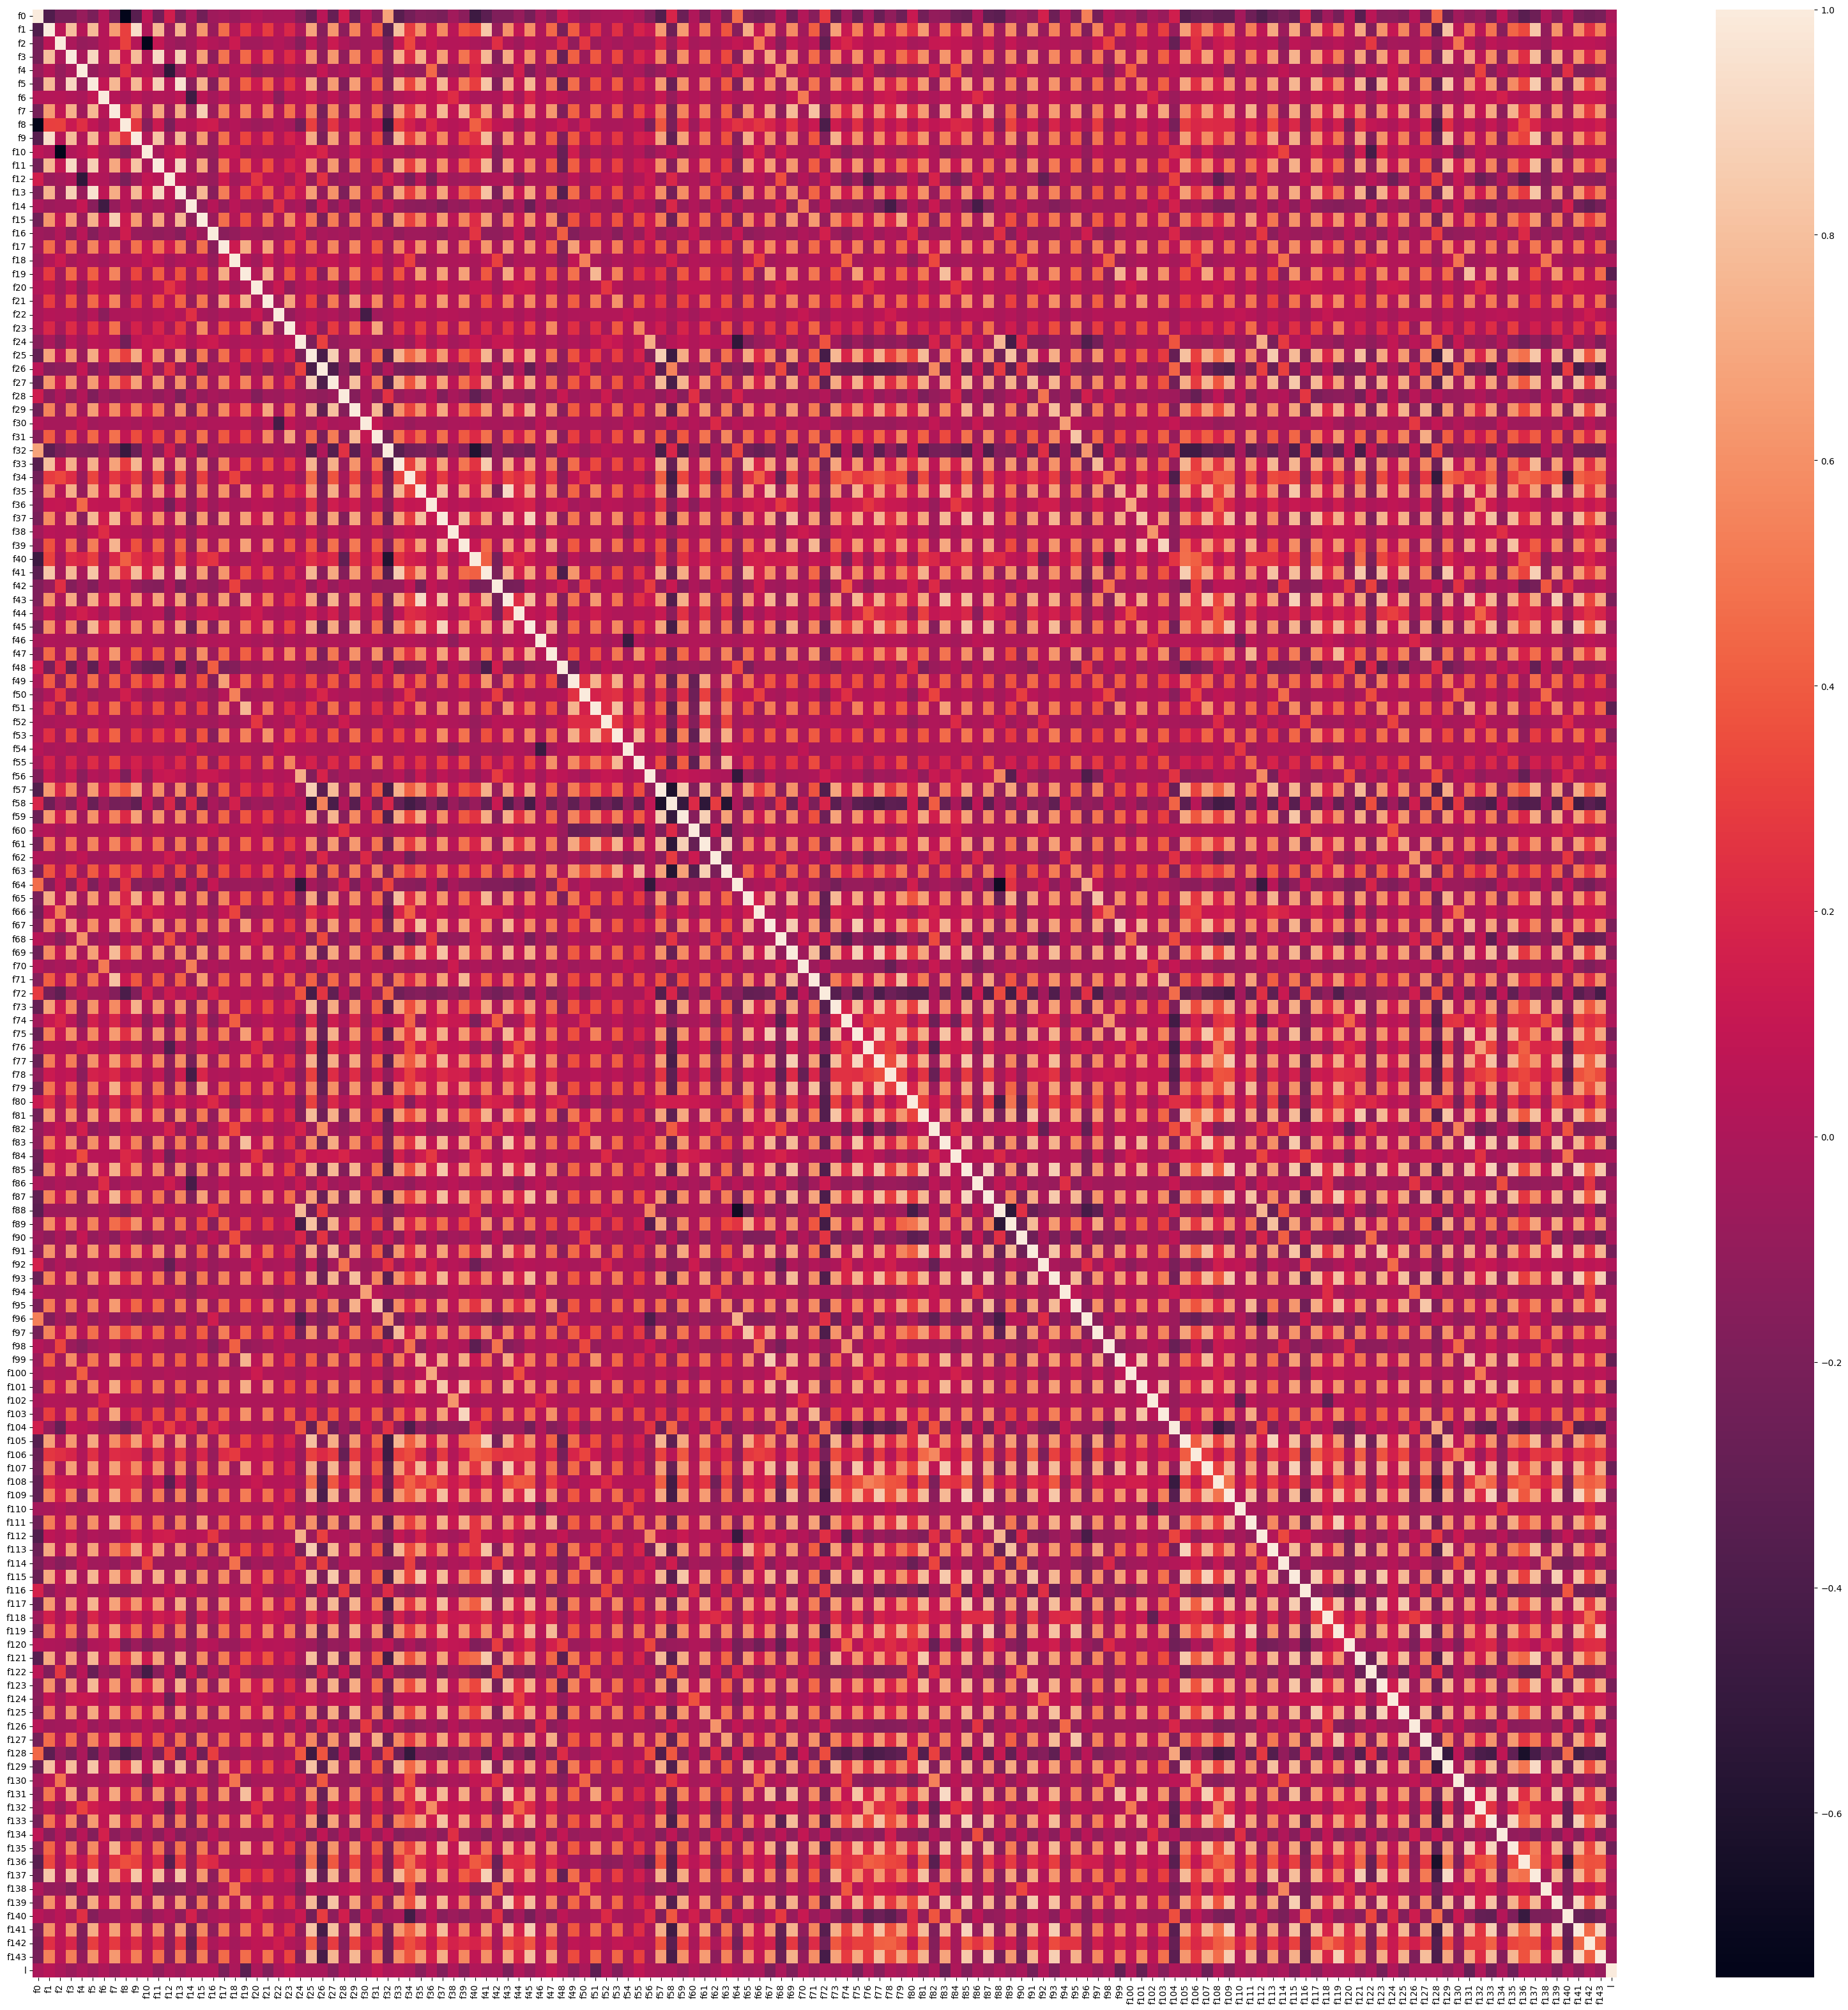

In [35]:
aaaa = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
column_names = [f'f{i}' for i in range(X_train.shape[1])] + ['l']
aaaa_df = pd.DataFrame(aaaa, columns=column_names)

corrcoef_matrix = aaaa_df.corr()
plt.figure(figsize=(40, 40))
sns.heatmap(corrcoef_matrix) # , annot=True, square=True)
plt.show()

In [36]:
'''
0.8<|CorrCoef|: high correlation
0.5<|CorrCoef|<0.8: middle correlation
0.3<|CorrCoef|<0.5: low correlation
0.3<|CorrCoef|: no correlation
'''
corrcoefs = []
for i in range(X_train.shape[1]):
    x_ = X_train[:, i]
    y_ = y_train
    cov = ((x_ - x_.mean()) * (y_ - y_.mean())).mean()
    corrcoef = cov / (x_.std() * y_.std())
    corrcoefs.append(corrcoef)
corrcoefs = np.array(corrcoefs)

In [37]:
np.where(np.abs(corrcoefs)>0.5)

(array([], dtype=int64),)

In [38]:
np.where(np.abs(corrcoefs)<0.3)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]),)

#### distribution

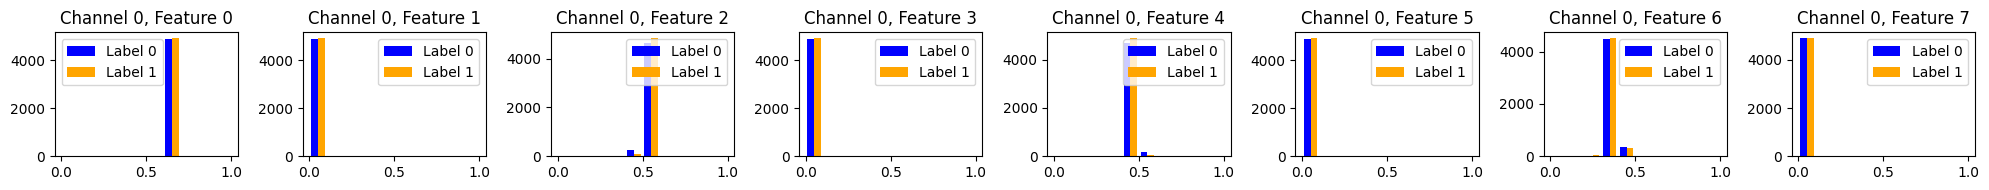

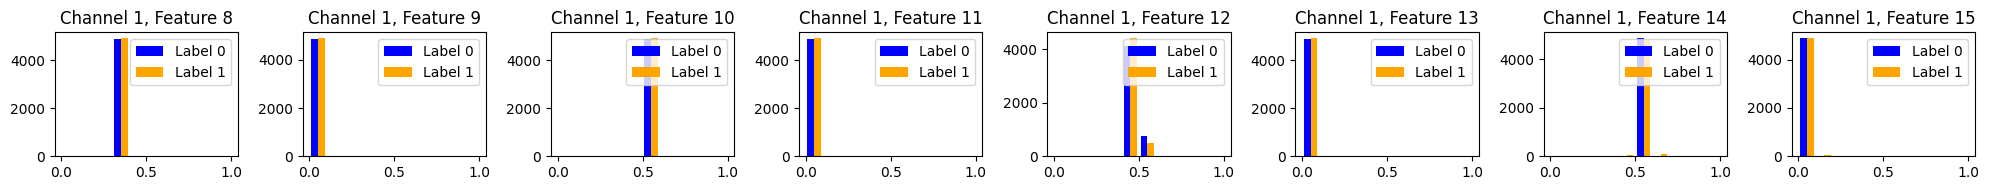

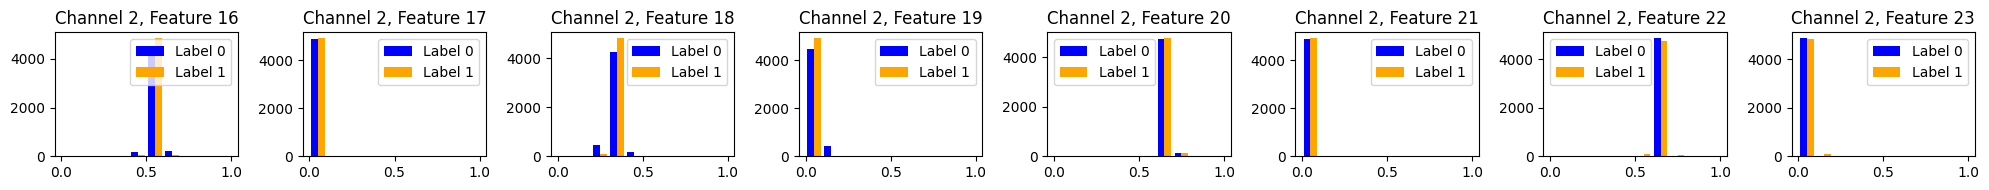

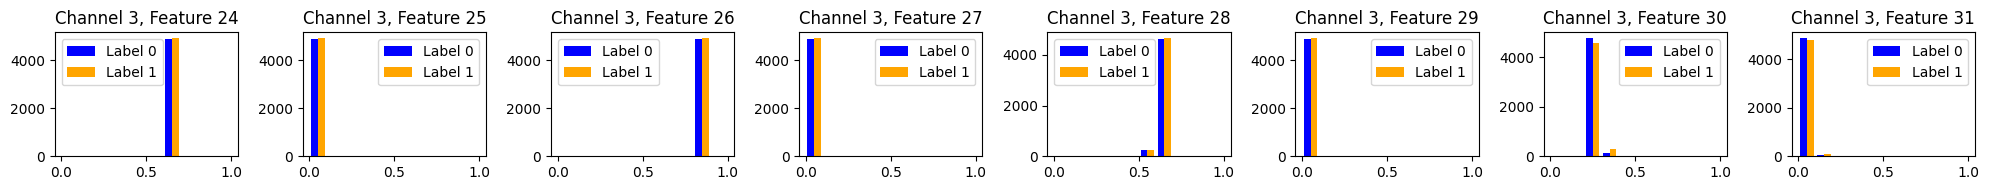

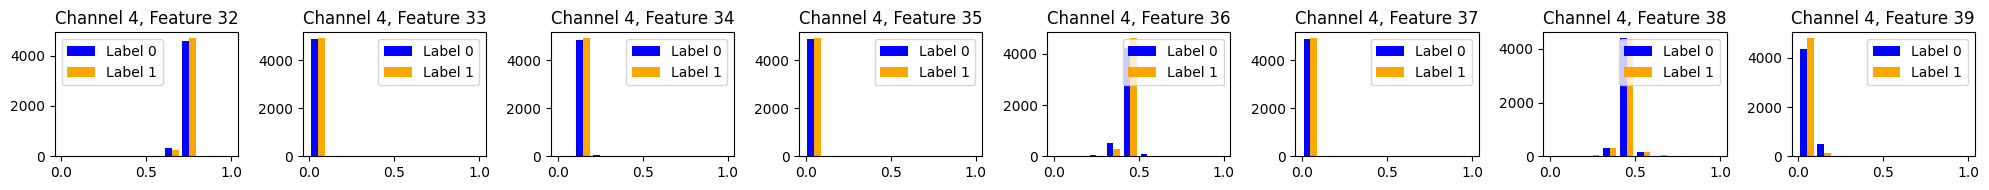

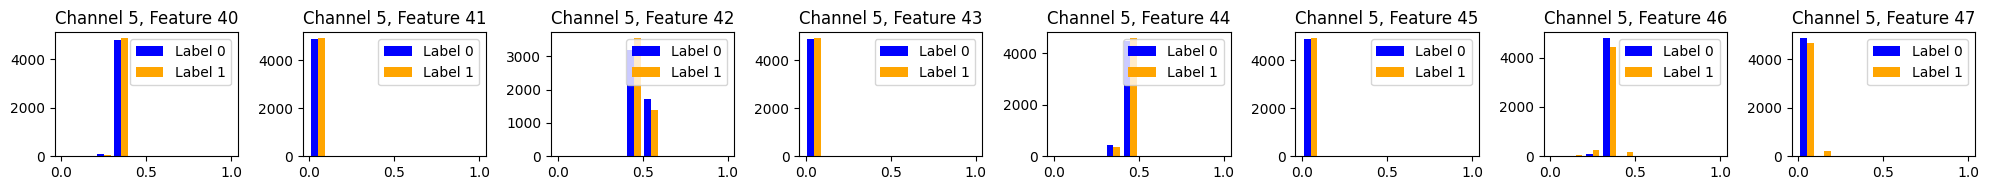

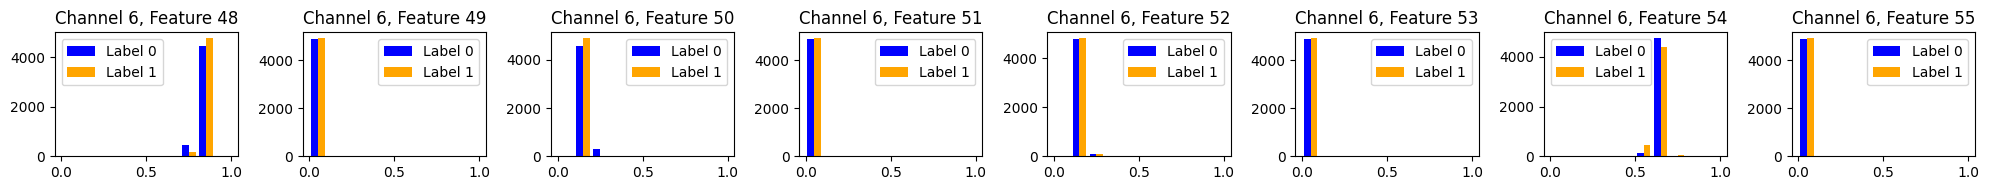

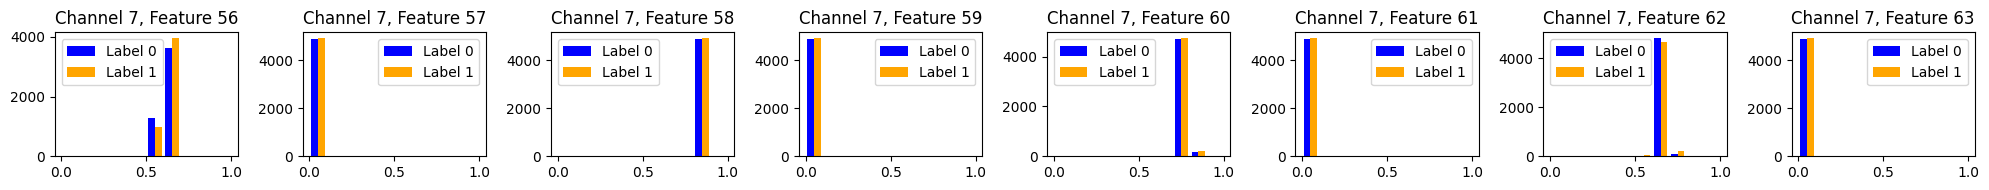

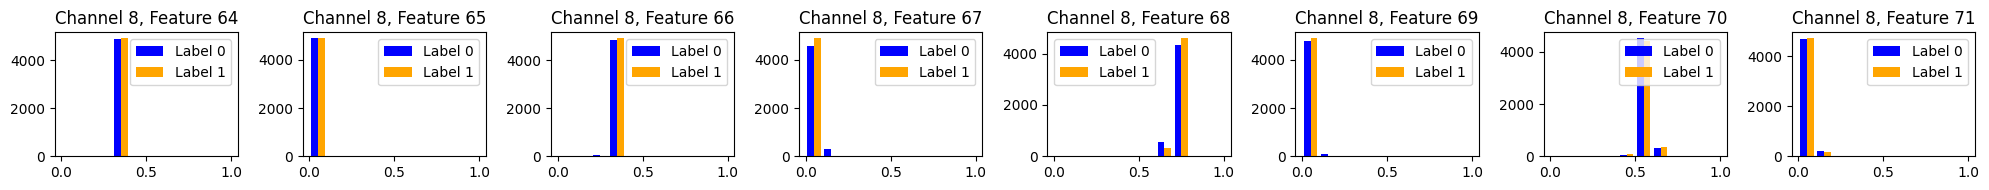

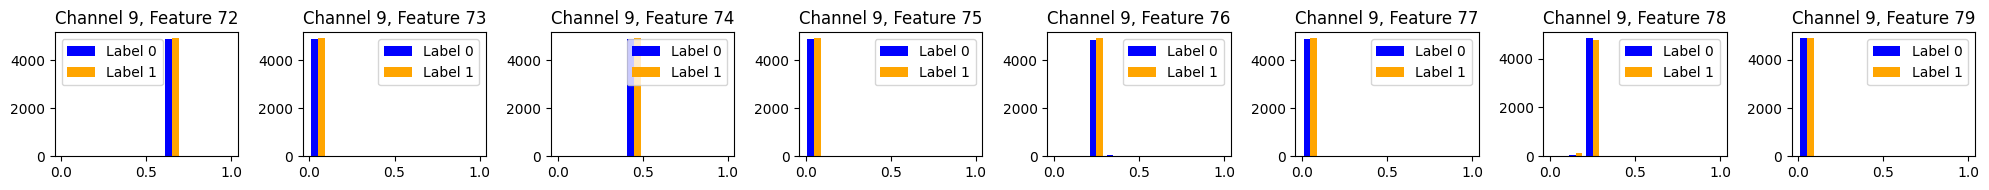

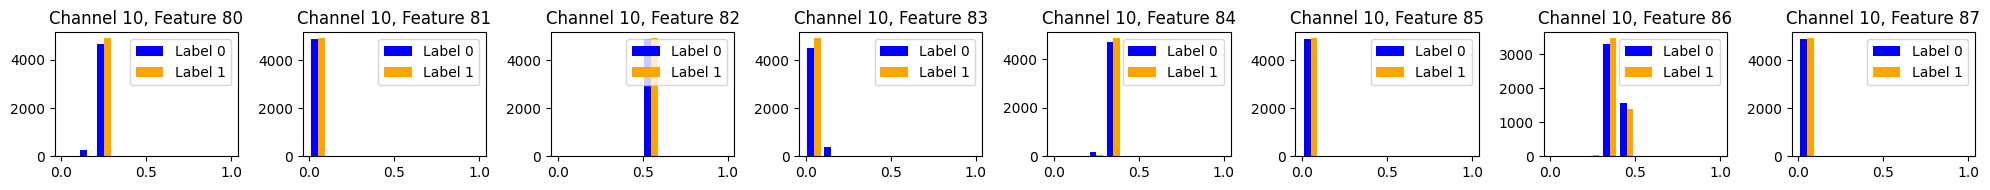

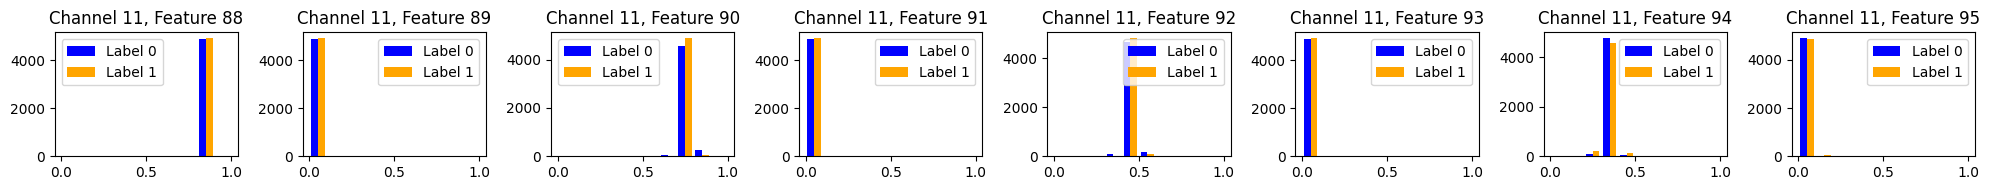

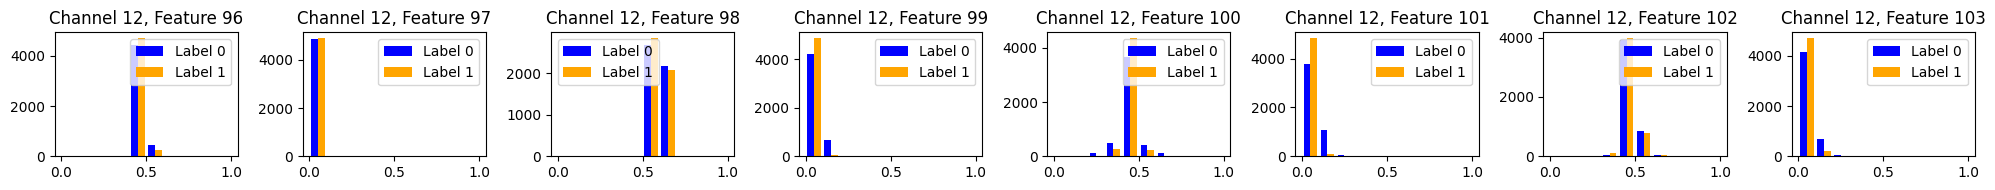

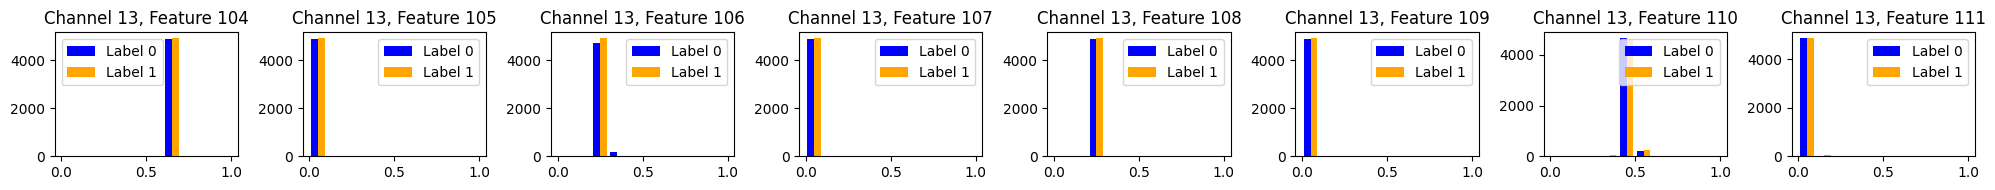

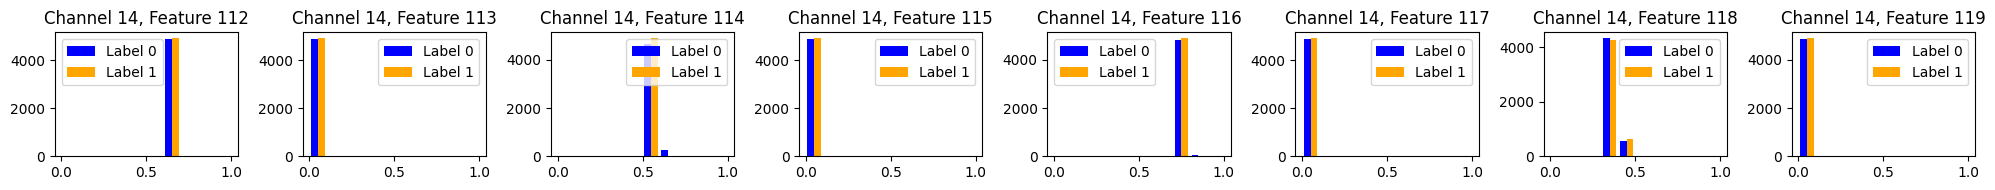

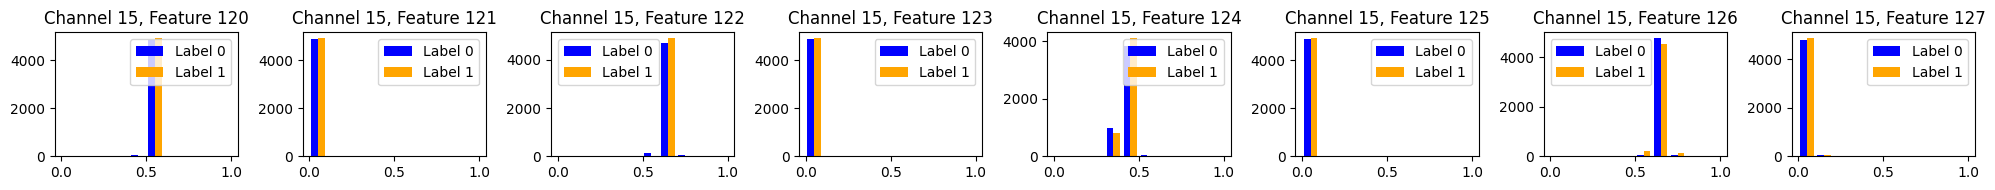

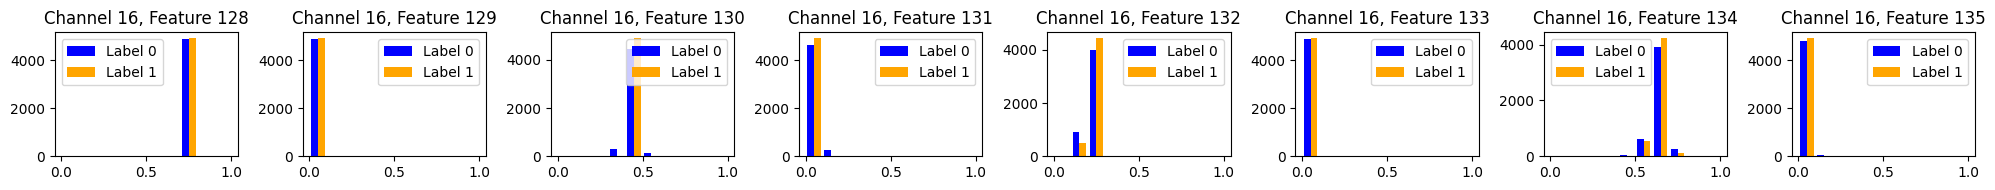

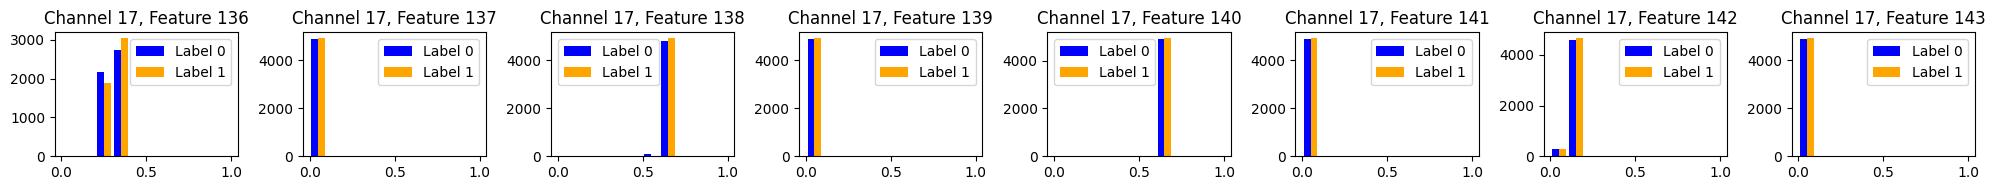

In [39]:
bbb_ = int(X_train.shape[1]/18)
for i in range(18):
    plt.figure(figsize=(20, 2))
    for j in range(bbb_):
        plt.subplot(1, bbb_, j+1)
        x_0 = X_train[:, i*bbb_+j][y_train == 0]
        x_1 = X_train[:, i*bbb_+j][y_train == 1]
        plt.hist([x_0, x_1], bins=10, color=['blue', 'orange'], label=['Label 0', 'Label 1'])
        plt.legend()
        # plt.xlabel('Feature Value')
        # plt.ylabel('Number of Samples')
        plt.title('Channel {}, Feature {}'.format(i, i*bbb_+j))
    plt.tight_layout()
    plt.show()

## 6. PCA

In [41]:
# model
pca = PCA(n_components=10)

X_pca = pca.fit_transform(X)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.fit_transform(X_val)
X_test_pca = pca.fit_transform(X_test)
X_train_pca.shape, X_val_pca.shape, X_test_pca.shape

((9833, 10), (2459, 10), (3094, 10))

#### visualize PC distribution

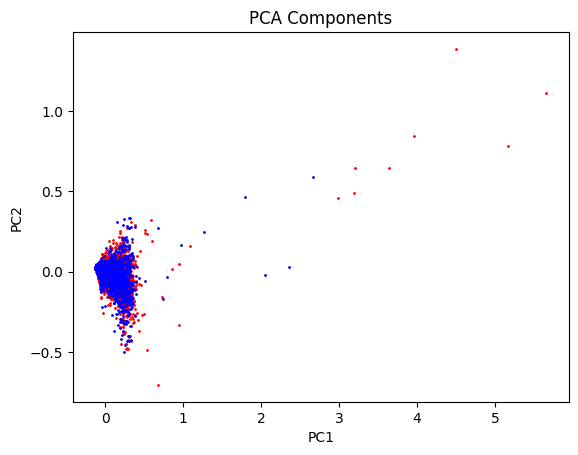

In [42]:
colors = ['red', 'blue']
for i in range(len(X_train_pca)):
    plt.scatter(X_train_pca[i, 0], X_train_pca[i, 1], color=colors[y[i]], s=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Components')
plt.show()

## 7. just find good models (via training set & validation set)

#### various classifiers
```
slow training: GBDT (GradientBoostingClassifier)
good scoor: SVC, LinearSVC, RandomForest, ExtraTreesClassifier, GBDT, XGBoost, KNN
```

In [43]:
models = [LogisticRegression(), SVC(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(),
          ExtraTreesClassifier(), GradientBoostingClassifier(), XGBClassifier(), KNeighborsClassifier(), GaussianNB()
]

names = ['LogisticRegression', 'SVC', 'LinearSVC', 'DecisionTreeClassifier', 'RandomForestClassifier',
          'ExtraTreesClassifier', 'GradientBoostingClassifier', 'XGBClassifier', 'KNeighborsClassifier', 'GaussianNB'
]

#### cross validation (or stratified K-folds) & various metrics 
<img src = './cross_validation.png' alt='drawing' height='350'/>

In [44]:
def acc_cv(model, X, y):
    acc = cross_val_score(model, X, y, scoring='accuracy', cv=skf) # cv=num_folds for cross-validation, or cv=skf for stratified K-folds cross-validation
    return acc
def balanced_acc_cv(model, X, y):
    balanced_acc = cross_val_score(model, X, y, scoring=make_scorer(balanced_accuracy_score), cv=skf)
    return balanced_acc
def precision_cv(model, X, y):
    precision = cross_val_score(model, X, y, scoring='precision', cv=skf)
    return precision
def recall_cv(model, X, y):
    recall = cross_val_score(model, X, y, scoring='recall', cv=skf)
    return recall
def f1_score_cv(model, X, y):
    f1_score = cross_val_score(model, X, y, scoring='f1', cv=skf)
    return f1_score
def auc_cv(model, X, y):
    auc = cross_val_score(model, X, y, scoring=make_scorer(roc_auc_score), cv=skf)
    return auc

#### can select with PCA or without PCA

In [44]:
for name, model in zip(names, models):
    print('----------', name, '----------')
    # acc
    score = acc_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||acc||', score.mean(), score.std()))
    # balanced acc
    score = balanced_acc_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||balanced_acc||', score.mean(), score.std()))
    # precision
    score = precision_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||precision||', score.mean(), score.std()))
    # recall
    score = recall_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||recall||', score.mean(), score.std()))
    # f1-score
    score = f1_score_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||f1||', score.mean(), score.std()))
    # auc
    score = auc_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||auc||', score.mean(), score.std()))
    print()

---------- LogisticRegression ----------
||acc||                 mean: 0.7306    std: 0.0124
||balanced_acc||        mean: 0.7305    std: 0.0085
||precision||           mean: 0.6831    std: 0.0110
||recall||              mean: 0.8661    std: 0.0156
||f1||                  mean: 0.7633    std: 0.0070
||auc||                 mean: 0.7318    std: 0.0079

---------- SVC ----------
||acc||                 mean: 0.6560    std: 0.0063
||balanced_acc||        mean: 0.6561    std: 0.0086
||precision||           mean: 0.5939    std: 0.0060
||recall||              mean: 0.9875    std: 0.0034
||f1||                  mean: 0.7420    std: 0.0029
||auc||                 mean: 0.6560    std: 0.0059

---------- LinearSVC ----------
||acc||                 mean: 0.7615    std: 0.0088
||balanced_acc||        mean: 0.7639    std: 0.0105
||precision||           mean: 0.7198    std: 0.0049
||recall||              mean: 0.8567    std: 0.0096
||f1||                  mean: 0.7821    std: 0.0063
||auc||        

## 8. hyperparameter tuning for getting best model (via training set & validation set)

#### grid search (or randomized search) & cross validation (or stratified K-folds)

In [ ]:
class GridSearch():
    def __init__(self, model):
        self.model = model
    
    def grid_get(self, X, y, param_grid, metric):
        grid_search_CV = GridSearchCV(estimator=self.model, param_grid=param_grid, cv=skf, scoring=metric)
        grid_search_CV.fit(X, y)
        
        best_params = grid_search_CV.best_params_
        best_score = grid_search_CV.best_score_
        print('best params:', best_params)
        print('best score:', best_score)
        # grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        # print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])
        
        return best_params, grid_search_CV


class RandomizedSearch():
    def __init__(self, model):
        self.model = model
    
    def grid_get(self, X, y, random_grid, metric):
        randomized_search_CV = RandomizedSearchCV(
            estimator=model, 
            param_distributions = random_grid, 
            n_iter=100, 
            cv=skf, 
            scoring=metric,
            verbose=2, 
            random_state=4321, 
            n_jobs=-1
        )       
        randomized_search_CV.fit(X, y)

        best_params = randomized_search_CV.best_params_
        best_score = randomized_search_CV.best_score_
        print('best params:', best_params)
        print('best score:', best_score)
    
        return best_params, randomized_search_CV

#### SVC (grid search)

In [ ]:
param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 0.001, 0.0001]
}

model = SVC(random_state=4321, probability=True)
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hypers.hyper_search_metric)
best_model_svc = gs_cv.best_estimator_

#### SVC (randomized search)

In [ ]:
# random_grid = {
#     'kernel': ['linear', 'rbf', 'poly'],
#     'C': uniform(loc=0.1, scale=10),
#     'gamma': [0.1, 0.001, 0.0001] # 'gamma': ['scale', 'auto']
# }

# model = SVC(random_state=4321)
# best_params, gs_cv = RandomizedSearch(model).grid_get(X, y, random_grid, hypers.hyper_search_metric)
# best_model_svc = gs_cv.best_estimator_

#### LinearSVC (grid search)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'dual': [True, False], # set dual=False when n_samples > n_features
}

model = LinearSVC(random_state=4321)
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hypers.hyper_search_metric)
best_model_linearsvc = gs_cv.best_estimator_

#### RandomForest (randomized search)

In [ ]:
random_grid = {
    'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4], 
    'bootstrap': [True, False]
}

model = RandomForestClassifier(random_state=4321)
best_params, gs_cv = RandomizedSearch(model).grid_get(X, y, random_grid, hypers.hyper_search_metric)
best_model_randomforest = gs_cv.best_estimator_

#### ExtraTreesClassifier (grid search)

In [ ]:
param_grid = {
    'n_estimators': [320, 340, 360, 380, 400],
    'max_depth': [25, 30, 32, 34, 38, 45]
}

model = ExtraTreesClassifier(random_state=4321)
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hypers.hyper_search_metric)
best_model_extratrees = gs_cv.best_estimator_

#### GBDT (grid search)

In [ ]:
param_grid = {
    #'nthread':[3,4], # when use hyperthread, xgboost may become slower
    'criterion': ['friedman_mse', 'mae'],
    'loss': ['deviance', 'exponential'],
    'max_features': ['log2', 'sqrt'],
    'learning_rate': [0.01, 0.05, 0.1, 1, 0.5],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [4, 5, 6],
    'subsample': [0.6, 0.7, 0.8],
    'n_estimators': [5, 10, 15, 20], # number of trees, change it to 1000 for better results
}

model = GradientBoostingClassifier(random_state=4321)
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hypers.hyper_search_metric)
best_model_gbdt = gs_cv.best_estimator_

#### XGBoost (grid search)

In [ ]:
param_grid = {
    'nthread':[2, 3],
    'eta': [0.01, 0.1, 1.0],
    'gamma':[0, 0.1], 
    'n_estimators':[10, 100],
    'max_depth':[2, 4], 
    'min_child_weigh':[1, 2]
}

model = XGBClassifier(random_state=4321, verbosity=0, probability=True) 
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hypers.hyper_search_metric)
best_model_xgboost = gs_cv.best_estimator_

#### KNN (grid search)

In [ ]:
param_grid = {
    'n_neighbors':list(range(1, 31))
}

model = KNeighborsClassifier()
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hypers.hyper_search_metric)
best_model_knn = gs_cv.best_estimator_

In [ ]:
# # logistic regression
# {'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]}

# # decision tree
# "criterion":("gini", "entropy"), "splitter":("best", "random"), "max_depth":(list(range(1, 20))), "min_samples_split":[2, 3, 4], "min_samples_leaf":list(range(1, 20)), 

# # naive bayes
# {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]}

## 9. final test (via test set)

In [ ]:
best_model_list = [best_model_svc, best_model_linearsvc, best_model_randomforest, best_model_extratrees, best_model_gbdt, best_model_xgboost, best_model_knn]

==================== SVC ====================
========== train ==========
                precision    recall  f1-score   support

    0: seizure       0.98      0.96      0.97       429
1: non-seizure       0.96      0.98      0.97       438

      accuracy                           0.97       867
     macro avg       0.97      0.97      0.97       867
  weighted avg       0.97      0.97      0.97       867



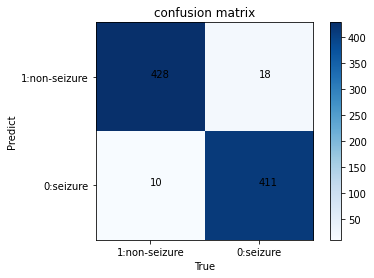

========== val ==========
                precision    recall  f1-score   support

    0: seizure       1.00      0.95      0.97       113
1: non-seizure       0.95      1.00      0.97       104

      accuracy                           0.97       217
     macro avg       0.97      0.97      0.97       217
  weighted avg       0.97      0.97      0.97       217



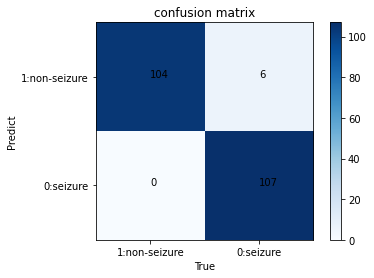

========== test ==========
                precision    recall  f1-score   support

    0: seizure       0.99      0.95      0.97       148
1: non-seizure       0.95      0.99      0.97       148

      accuracy                           0.97       296
     macro avg       0.97      0.97      0.97       296
  weighted avg       0.97      0.97      0.97       296



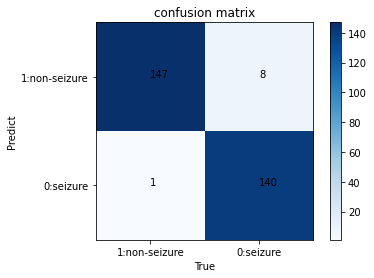

==================== LinearSVC ====================
========== train ==========
                precision    recall  f1-score   support

    0: seizure       0.97      0.93      0.95       429
1: non-seizure       0.93      0.97      0.95       438

      accuracy                           0.95       867
     macro avg       0.95      0.95      0.95       867
  weighted avg       0.95      0.95      0.95       867



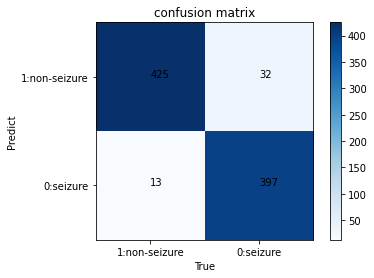

========== val ==========
                precision    recall  f1-score   support

    0: seizure       0.99      0.92      0.95       113
1: non-seizure       0.92      0.99      0.95       104

      accuracy                           0.95       217
     macro avg       0.96      0.96      0.95       217
  weighted avg       0.96      0.95      0.95       217



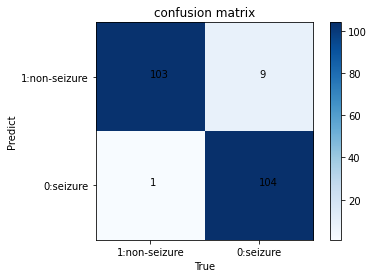

========== test ==========
                precision    recall  f1-score   support

    0: seizure       0.98      0.93      0.96       148
1: non-seizure       0.94      0.98      0.96       148

      accuracy                           0.96       296
     macro avg       0.96      0.96      0.96       296
  weighted avg       0.96      0.96      0.96       296



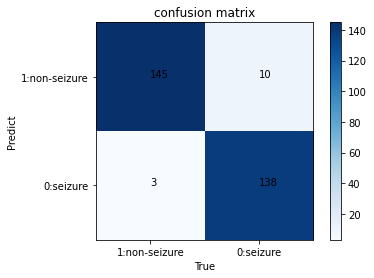

==================== RandomForestClassifier ====================
========== train ==========
                precision    recall  f1-score   support

    0: seizure       1.00      1.00      1.00       429
1: non-seizure       1.00      1.00      1.00       438

      accuracy                           1.00       867
     macro avg       1.00      1.00      1.00       867
  weighted avg       1.00      1.00      1.00       867



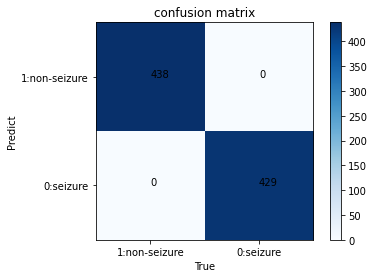

========== val ==========
                precision    recall  f1-score   support

    0: seizure       1.00      1.00      1.00       113
1: non-seizure       1.00      1.00      1.00       104

      accuracy                           1.00       217
     macro avg       1.00      1.00      1.00       217
  weighted avg       1.00      1.00      1.00       217



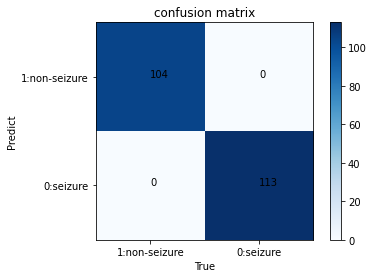

========== test ==========
                precision    recall  f1-score   support

    0: seizure       0.99      0.96      0.97       148
1: non-seizure       0.96      0.99      0.97       148

      accuracy                           0.97       296
     macro avg       0.97      0.97      0.97       296
  weighted avg       0.97      0.97      0.97       296



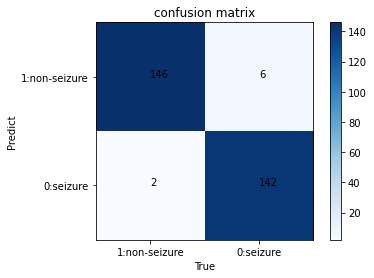

==================== ExtraTreesClassifier ====================
========== train ==========
                precision    recall  f1-score   support

    0: seizure       1.00      1.00      1.00       429
1: non-seizure       1.00      1.00      1.00       438

      accuracy                           1.00       867
     macro avg       1.00      1.00      1.00       867
  weighted avg       1.00      1.00      1.00       867



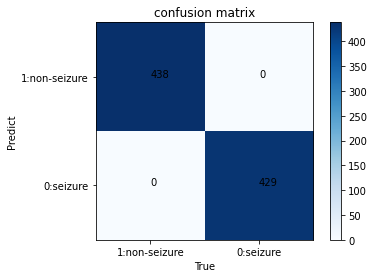

========== val ==========
                precision    recall  f1-score   support

    0: seizure       1.00      1.00      1.00       113
1: non-seizure       1.00      1.00      1.00       104

      accuracy                           1.00       217
     macro avg       1.00      1.00      1.00       217
  weighted avg       1.00      1.00      1.00       217



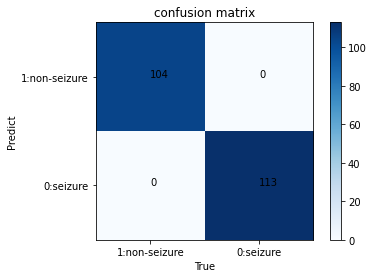

========== test ==========
                precision    recall  f1-score   support

    0: seizure       0.99      0.95      0.97       148
1: non-seizure       0.95      0.99      0.97       148

      accuracy                           0.97       296
     macro avg       0.97      0.97      0.97       296
  weighted avg       0.97      0.97      0.97       296



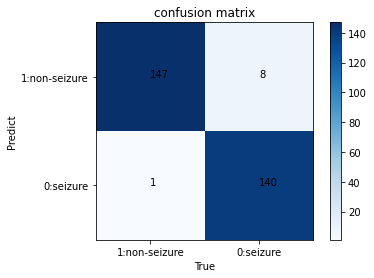

==================== GradientBoostingClassifier ====================
========== train ==========
                precision    recall  f1-score   support

    0: seizure       0.99      0.97      0.98       429
1: non-seizure       0.98      0.99      0.98       438

      accuracy                           0.98       867
     macro avg       0.98      0.98      0.98       867
  weighted avg       0.98      0.98      0.98       867



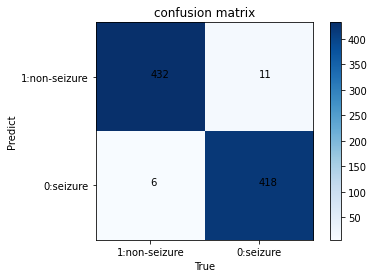

========== val ==========
                precision    recall  f1-score   support

    0: seizure       1.00      0.97      0.99       113
1: non-seizure       0.97      1.00      0.99       104

      accuracy                           0.99       217
     macro avg       0.99      0.99      0.99       217
  weighted avg       0.99      0.99      0.99       217



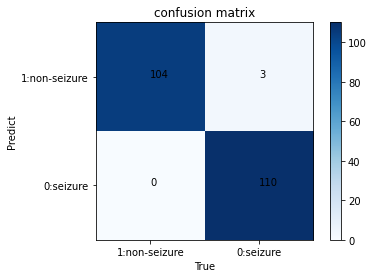

========== test ==========
                precision    recall  f1-score   support

    0: seizure       0.99      0.95      0.97       148
1: non-seizure       0.95      0.99      0.97       148

      accuracy                           0.97       296
     macro avg       0.97      0.97      0.97       296
  weighted avg       0.97      0.97      0.97       296



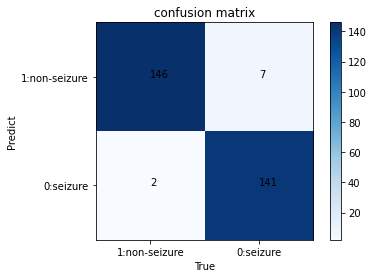

==================== XGBClassifier ====================
========== train ==========
                precision    recall  f1-score   support

    0: seizure       1.00      1.00      1.00       429
1: non-seizure       1.00      1.00      1.00       438

      accuracy                           1.00       867
     macro avg       1.00      1.00      1.00       867
  weighted avg       1.00      1.00      1.00       867



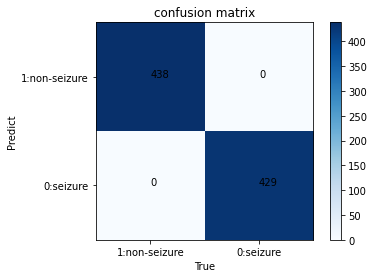

========== val ==========
                precision    recall  f1-score   support

    0: seizure       1.00      1.00      1.00       113
1: non-seizure       1.00      1.00      1.00       104

      accuracy                           1.00       217
     macro avg       1.00      1.00      1.00       217
  weighted avg       1.00      1.00      1.00       217



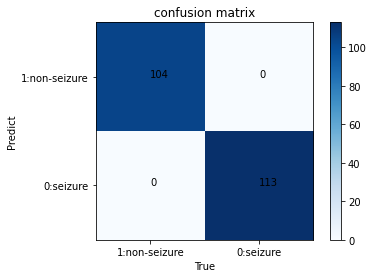

========== test ==========
                precision    recall  f1-score   support

    0: seizure       0.98      0.95      0.96       148
1: non-seizure       0.95      0.98      0.96       148

      accuracy                           0.96       296
     macro avg       0.96      0.96      0.96       296
  weighted avg       0.96      0.96      0.96       296



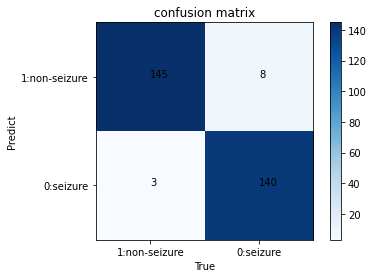

==================== KNeighborsClassifier ====================
========== train ==========
                precision    recall  f1-score   support

    0: seizure       0.98      0.96      0.97       429
1: non-seizure       0.96      0.98      0.97       438

      accuracy                           0.97       867
     macro avg       0.97      0.97      0.97       867
  weighted avg       0.97      0.97      0.97       867



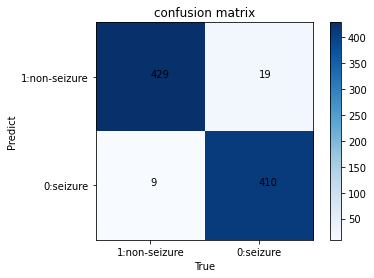

========== val ==========
                precision    recall  f1-score   support

    0: seizure       0.99      0.94      0.96       113
1: non-seizure       0.94      0.99      0.96       104

      accuracy                           0.96       217
     macro avg       0.96      0.96      0.96       217
  weighted avg       0.96      0.96      0.96       217



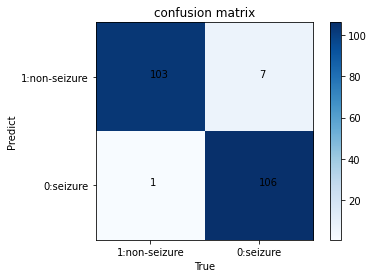

========== test ==========
                precision    recall  f1-score   support

    0: seizure       0.96      0.92      0.94       148
1: non-seizure       0.92      0.96      0.94       148

      accuracy                           0.94       296
     macro avg       0.94      0.94      0.94       296
  weighted avg       0.94      0.94      0.94       296



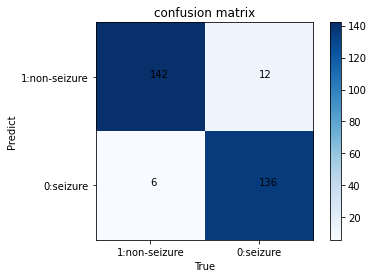

In [ ]:
utils.report_and_confusion_matrix(best_model_list, X_train, y_train, X_val, y_val, X_test, y_test, utils.confusion_matrix, hypers.labels)

SVC:99.05%
LinearSVC:98.72%
RandomForestClassifier:99.77%
ExtraTreesClassifier:99.78%
GradientBoostingClassifier:99.38%
XGBClassifier:99.60%
KNeighborsClassifier:95.09%


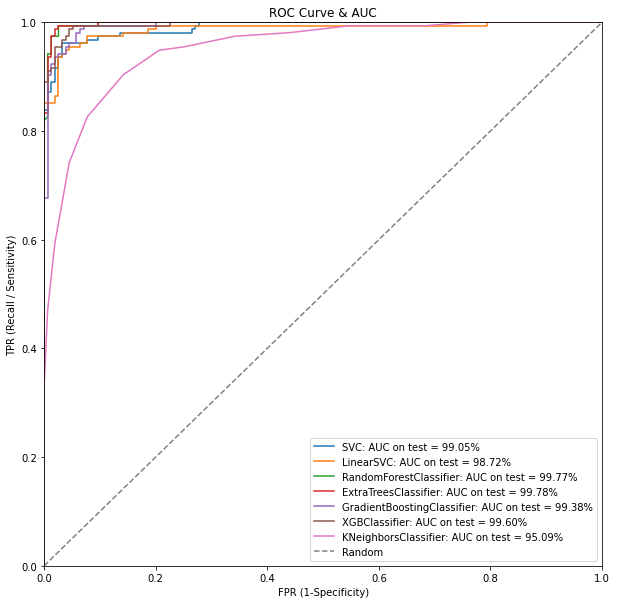

In [ ]:
utils.roc_and_auc(best_model_list, X_test, y_test, roc_curve)

#### 3 Metrics of Epileptic Seizure Detection: Accuracy, Sensitivity (Recall), Specificity

In [ ]:
y_test_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_test_pred))
print('Sensitivity/Recall:', recall_score(y_test, y_test_pred, pos_label=0)) # 敏感性, 默认计算正例标签1的召回率
print('Specificity:', recall_score(y_test, y_test_pred, pos_label=1)) # 特异性

## 10. save best model & best hyperparameters for demo
```
save & load trained model:
    - joblib.dump, joblib.load
    - pickle.dump, pickle.load

save & load hyperparameters:
    - clf.best_params_
```

In [161]:
joblib.dump(scaler, './DataSection-EEG/scaler.pkl')

['./DataSection-EEG/scaler.pkl']

In [162]:
with open('./DataSection-EEG/best_model.pkl', mode='wb') as f:
    pickle.dump(clf, f, protocol=2)